In [1]:
!pip install -qU langchain langsmith langchain-core langchain-community langchain-experimental langchain-openai langchain-groq pypdf langchain-text-splitters langchain-chroma faiss-cpu sentence_transformers google-search-results wikipedia duckduckgo-search arxiv langgraph yfinance

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.4/326.4 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

# Load Envs

In [2]:
import os
from google.colab import userdata
# os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
# os.environ['HUGGINGFACEHUB_API_TOKEN'] = userdata.get('HUGGINGFACEHUB_API_TOKEN')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
# os.environ['SERPAPI_API_KEY'] = userdata.get('SERPAPI_API_KEY')

# Setup Langsmith

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "langgraph_learning"

# Routing

## 1. Tool Condition

[Tool Condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/)

[Github](https://github.com/langchain-ai/langgraph/blob/main/libs/langgraph/langgraph/prebuilt/tool_node.py)


```
if isinstance(state, list):
  ai_message = state[-1]
elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
  ai_message = messages[-1]
elif messages := getattr(state, messages_key, []):
  ai_message = messages[-1]
else:
  raise ValueError(f"No messages found in input state to tool_edge: {state}")
if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
  return "tools"
return "__end__"
```

This in the end by default will call `__end__` node

In [4]:
from langgraph.prebuilt import ToolNode, tools_condition

In [5]:
# graph.add_node("tools", ToolNode(tools)) # the name of this node should always be tools

# graph_builder.add_conditional_edges(
#     "Agent",
#     tools_condition
# ... )

## 2. ToolNode

### Tool Calling - Function Calling

Understand why we need to bind_tools.

### [Tool calling](https://python.langchain.com/v0.1/docs/modules/model_io/chat/function_calling/)

Tool calling allows a model to respond to a given prompt by generating output that matches a user-defined schema. While the name implies that the model is performing some action, this is actually not the case! The model is coming up with the arguments to a tool, and **actually running the tool (or not) is up to the user**

---

> The model is coming up with the arguments to a tool, and **actually running the tool (or not) is up to the user**.

---


For a model to be able to invoke tools, you need to pass tool schemas to it when making a chat request.

LangChain ChatModels supporting tool calling features implement a `.bind_tools` method, which receives a list of LangChain tool objects, Pydantic classes, or JSON Schemas and binds them to the chat model in the provider-specific expected format.

Subsequent invocations of the bound chat model will include tool schemas in every call to the model API.

# Notebook 8

https://colab.research.google.com/drive/1AdRF84LakHpq_tTBb5Qw4yI_zPdFPg2j?authuser=5#scrollTo=J038xtseL2p5

## 3. Intent Classifier as Router

The detected intent will be one from the following

```
[Restaurant, Wikipedia, Search, Not Restaurant]

[Restaurant -> Call Rag Tool]
[Wikipedia -> Call Wikipedia Tool]
[Search -> Call Search Tool]
[Not Restaurant -> Call LLM Tool]
```

Mapping Works Like:



```
# This is formatted as code

{
  "Call Rag Tool" : RAG Node,
  "Call Wikipedia Tool" : Wikipedia Node,
  "Call Search Tool" : Search Node,
  "Call LLM Tool" : LLM Node

}
```

In [7]:
def router():
  print("---------- Router ----------")

  intent_detected = state["messages"][-1]

  if intent_detected == "Restaurant":
    return "Call Rag Tool"
  elif intent_detected == "Wikipedia":
    return "Call Wikipedia Tool"
  elif intent_detected == "Search":
    return "Call Search Tool"
  else:
    return "Call LLM Tool"

# Build Finance Bot

In [10]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI()

## Adding Memory

In [11]:
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Create State for the Bot

In [12]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
  query: str
  messages: Annotated[list[MessagesState], add_messages]

## Tools

In [13]:
# Prebuilt Tools

from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()


from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [14]:
# Custom Tools

from langchain_core.tools import tool

@tool
def random_func(user_input: str) -> str:
  """
  Surprises user with a random fact.

  Args:
    user_input: string.

  Returns:
    A random fact: String.
  """
  random_prompt = "Surprise the user with something random about {user_input}".format(user_input=user_input)
  return llm.predict(random_prompt)

In [15]:
import yfinance as yf

@tool
def get_stock_price(ticker: str) -> float:
  """
  Gets a stock price from Yahoo Finance.

  Args:
      ticker: ticker str

  Returns:
    price: float
  """
  # """This is a tool for getting the price of a stock when passed a ticker symbol"""
  stock = yf.Ticker(ticker)
  print(stock)
  print(stock.info)
  return stock.info['previousClose']

In [16]:
tools = [search, wikipedia, random_func, get_stock_price]

Bind Tools

In [17]:
llm_with_tools = llm.bind_tools(tools)

Tool Node

In [18]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools)

## Agent

In [19]:
from langchain_core.messages import HumanMessage, SystemMessage

In [20]:
template = """
  You are a helpful assistant.
  As an assistant you are tasked with using search, wikepedia, the yahoo finance tool to get stock price or a random func to brighten the user based on their query.
""".strip()

In [21]:
template

'You are a helpful assistant. \n  As an assistant you are tasked with using search, wikepedia, the yahoo finance tool to get stock price or a random func to brighten the user based on their query.'

In [22]:
def agentic_func(state: State):
  print("------------ Tool Calling Func ----------")
  print("state: ", state)

  query = state['query']
  messages = state['messages'] # pass the entire state

  # SystemMessage
  system_message = SystemMessage(content=template)
  print("system_message : ", system_message)
  # messages.append(system_message)

  # HumanMessage
  human_message = HumanMessage(content=query)
  print("human_message : ", human_message)
  messages.append(human_message)
  print("messages : ", messages)

  # final query
  final_query = [system_message] + messages
  print("final_query: ", final_query)

  result = llm_with_tools.invoke(final_query)

  return {"messages" : [result]}

## Build Graph

In [23]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition

In [24]:
# 1. Create Instance of the Graph
workflow = StateGraph(State)


# 2. Create Nodes
workflow.add_node("Agent", agentic_func)
workflow.add_node("tools", tool_node) # this node should be named as tools


# 3. Create Conditional Edges
workflow.add_conditional_edges(
    "Agent",   # Tool Calling
    tools_condition, # Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.

)

## Create Cyclic Edge
workflow.add_edge("tools", "Agent")

## Create Entry Point
workflow.add_edge(START, "Agent")


# 4. Compile the Graph
my_graph = workflow.compile(checkpointer=memory) # add memory here

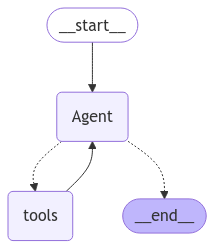

In [25]:
# 5. Display the graph
from IPython.display import Image, display

try:
    display(Image(my_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

## Run Graph - Since we are useing tool_condition, we havent added structured output (That part can be excluded)

In [26]:
config = {"configurable": {"thread_id": "1"}}

In [27]:
query = "What is the current temperature in Michigan?"
user_input = {"query": query,
              "messages" : []}

In [28]:
result = my_graph.invoke(
    user_input, config, stream_mode="values"
)

------------ Tool Calling Func ----------
state:  {'query': 'What is the current temperature in Michigan?', 'messages': []}
system_message :  content='You are a helpful assistant. \n  As an assistant you are tasked with using search, wikepedia, the yahoo finance tool to get stock price or a random func to brighten the user based on their query.' additional_kwargs={} response_metadata={}
human_message :  content='What is the current temperature in Michigan?' additional_kwargs={} response_metadata={}
messages :  [HumanMessage(content='What is the current temperature in Michigan?', additional_kwargs={}, response_metadata={})]
final_query:  [SystemMessage(content='You are a helpful assistant. \n  As an assistant you are tasked with using search, wikepedia, the yahoo finance tool to get stock price or a random func to brighten the user based on their query.', additional_kwargs={}, response_metadata={}), HumanMessage(content='What is the current temperature in Michigan?', additional_kwargs={

In [29]:
result

{'query': 'What is the current temperature in Michigan?',
 'messages': [HumanMessage(content='What is the current temperature in Michigan?', additional_kwargs={}, response_metadata={}, id='9cc46a51-f82f-4e61-a2de-ddacd7059046'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rZoFNuxfVDpPXjCsw8mmee2z', 'function': {'arguments': '{"query":"current temperature in Michigan"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 276, 'total_tokens': 297, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-09c98398-5e8f-48cc-bca5-10abc73e6151-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query'

In [30]:
result['messages'][-1].content

'The current temperature in Michigan is around 23°F (-5°C) with noticeable clouds in the skyline.'